In [1]:
!pip install torch pandas numpy requests tqdm scikit-learn notebook ipywidgets tensorboard wandb

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.profiler import profile, record_function, ProfilerActivity

import pandas as pd
import numpy as np
import random
import math
import os
import requests
import zipfile
from tqdm.notebook import tqdm # Use tqdm.notebook for Jupyter!
from collections import defaultdict
import time
import datetime
import warnings
import wandb

# Ignore specific warnings if needed
# warnings.filterwarnings('ignore')

print(f"PyTorch Version: {torch.__version__}")
print(f"WandB Version: {wandb.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"Device Name: {torch.cuda.get_device_name(0)}")

# (Optional) Login to WandB if you haven't via CLI
# try:
#     wandb.login()
# except Exception as e:
#     print(f"Could not automatically log in to WandB: {e}")
#     print("Please ensure you have run 'wandb login' in your terminal or manually call wandb.login() here.")

PyTorch Version: 2.6.0+cu124
WandB Version: 0.19.9
CUDA Available: True
CUDA Version: 12.4
Device Name: NVIDIA A100-SXM4-40GB


In [3]:
class Config:
    # WandB parameters
    WANDB_PROJECT = "BERT4Rec-MovieLens_opt1" # Project name on WandB
    WANDB_ENTITY = None # Your WandB username or team (optional, defaults to your default entity)
    RUN_NAME = f"bert4rec_ml20m_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}" # Unique run name

    # Data parameters
    DATASET_NAME = "ml-20m"
    DATA_URL = f"https://files.grouplens.org/datasets/movielens/{DATASET_NAME}.zip"
    DATA_DIR = "./data_bert4rec"
    RATINGS_FILE = f"{DATASET_NAME}/ratings.csv"
    MIN_USER_INTERACTIONS = 5
    MIN_ITEM_INTERACTIONS = 5
    TEST_NEG_SAMPLE_SIZE = 100

    # Model parameters
    max_len = 50
    hidden_units = 128
    num_blocks = 2
    num_heads = 4
    dropout_rate = 0.2
    mask_prob = 0.2

    # Training parameters
    epochs = 5
    batch_size = 512 # Increased for V100/A100
    lr = 1e-3
    optimizer_type = 'AdamW'
    weight_decay = 0.01
    num_workers = 8
    log_freq = 50 # Log batch loss every N batches to WandB/console
    profiler_enabled = True # Keep profiler if needed alongside WandB
    profile_batches = 50
    profile_warmup = 10
    profile_dir = "./log_bert4rec"

    # Special token indices
    PAD = 0
    MASK = -1

# Instantiate config
config = Config()

# --- Sanity Checks ---
if config.hidden_units % config.num_heads != 0:
    raise ValueError(f"hidden_units ({config.hidden_units}) must be divisible by num_heads ({config.num_heads})")

print("Configuration set.")
print(f"WandB Project: {config.WANDB_PROJECT}")
print(f"Run Name: {config.RUN_NAME}")
print(f"Batch Size: {config.batch_size}")
print(f"Hidden Units: {config.hidden_units}")
print(f"Num Workers: {config.num_workers}")
print(f"Using {config.optimizer_type} optimizer.")

Configuration set.
WandB Project: BERT4Rec-MovieLens_opt1
Run Name: bert4rec_ml20m_20250420_191350
Batch Size: 512
Hidden Units: 128
Num Workers: 8
Using AdamW optimizer.


In [4]:
def download_and_extract_data(config):
    """Downloads and extracts the MovieLens dataset."""
    os.makedirs(config.DATA_DIR, exist_ok=True)
    zip_path = os.path.join(config.DATA_DIR, f"{config.DATASET_NAME}.zip")
    extract_path = os.path.join(config.DATA_DIR)
    ratings_path = os.path.join(config.DATA_DIR, config.RATINGS_FILE)

    if not os.path.exists(ratings_path):
        print(f"Downloading {config.DATASET_NAME} dataset...")
        response = requests.get(config.DATA_URL, stream=True)
        response.raise_for_status()
        total_size = int(response.headers.get('content-length', 0))
        block_size = 1024 # 1 Kibibyte
        # Use tqdm for download progress
        progress_bar = tqdm(total=total_size, unit='iB', unit_scale=True, desc="Downloading")
        with open(zip_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=block_size):
                progress_bar.update(len(chunk))
                f.write(chunk)
        progress_bar.close()
        if total_size != 0 and progress_bar.n != total_size:
             print("ERROR, something went wrong during download")

        print("Download complete. Extracting...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print("Extraction complete.")
        os.remove(zip_path) # Clean up zip file
    else:
        print(f"Dataset found at {ratings_path}")

print("Data download function defined.")

Data download function defined.


In [5]:
def preprocess_data(config):
    """Loads ratings, filters users/items, creates sequences."""
    print("Loading and preprocessing data...")
    ratings_df = pd.read_csv(os.path.join(config.DATA_DIR, config.RATINGS_FILE))
    print(f"Initial ratings: {len(ratings_df)}")

    # Filter users
    user_counts = ratings_df['userId'].value_counts()
    valid_users = user_counts[user_counts >= config.MIN_USER_INTERACTIONS].index
    ratings_df = ratings_df[ratings_df['userId'].isin(valid_users)]
    print(f"Ratings after user filtering: {len(ratings_df)} ({len(valid_users)} users)")

    # Filter items
    item_counts = ratings_df['movieId'].value_counts()
    valid_items = item_counts[item_counts >= config.MIN_ITEM_INTERACTIONS].index
    ratings_df = ratings_df[ratings_df['movieId'].isin(valid_items)]
    print(f"Ratings after item filtering: {len(ratings_df)} ({len(valid_items)} items)")

    # Re-filter users
    user_counts = ratings_df['userId'].value_counts()
    valid_users = user_counts[user_counts >= config.MIN_USER_INTERACTIONS].index
    ratings_df = ratings_df[ratings_df['userId'].isin(valid_users)]
    print(f"Ratings after re-filtering users: {len(ratings_df)} ({len(valid_users)} users)")

    # Sort interactions
    ratings_df = ratings_df.sort_values(by=['userId', 'timestamp'])

    # Create mappings (item IDs start from 1)
    unique_users = ratings_df['userId'].unique()
    user_map = {user_id: i for i, user_id in enumerate(unique_users)}
    unique_items = ratings_df['movieId'].unique()
    item_map = {item_id: i + 1 for i, item_id in enumerate(unique_items)}
    num_items = len(item_map)
    config.MASK = num_items + 1 # Set MASK token index dynamically in the shared config object

    print(f"Number of unique users: {len(user_map)}")
    print(f"Number of unique items (vocab size): {num_items}")
    print(f"MASK token index set to: {config.MASK}")

    # Group interactions and create sequences
    user_sequences = ratings_df.groupby('userId')['movieId'].apply(list)
    processed_sequences = []
    for user_id, item_sequence in tqdm(user_sequences.items(), desc="Generating sequences"):
        mapped_sequence = [item_map[item] for item in item_sequence]
        # Create subsequences ending at each point
        for i in range(1, len(mapped_sequence)): # Start from 1 to have at least one item as label
            end_idx = i + 1
            start_idx = max(0, end_idx - config.max_len)
            seq = mapped_sequence[start_idx:end_idx]

            # Pad sequence
            padded_seq = ([config.PAD] * (config.max_len - len(seq))) + seq
            if len(padded_seq) != config.max_len:
                 print(f"Padding Error: User {user_id}, i={i}, len={len(padded_seq)}")
                 continue

            processed_sequences.append(padded_seq)

    print(f"Total number of sequences generated: {len(processed_sequences)}")

    # Split data (user-agnostic split for simplicity here)
    random.shuffle(processed_sequences)
    split_idx = int(len(processed_sequences) * 0.9)
    train_sequences = processed_sequences[:split_idx]
    val_sequences = processed_sequences[split_idx:]

    print(f"Train sequences: {len(train_sequences)}")
    print(f"Validation sequences: {len(val_sequences)}")

    return train_sequences, val_sequences, num_items, config.MASK # Return MASK index

print("Data preprocessing function defined.")

Data preprocessing function defined.


In [6]:
class MLDataset(Dataset):
    """MovieLens Dataset for BERT4Rec training."""
    def __init__(self, sequences, max_len, mask_prob, mask_token_idx, pad_token_idx, num_items):
        self.sequences = sequences
        self.max_len = max_len
        self.mask_prob = mask_prob
        self.mask_token_idx = mask_token_idx
        self.pad_token_idx = pad_token_idx
        self.num_items = num_items # Actual number of items (vocab size)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx] # Sequence of item IDs (padded)
        masked_input_seq = list(seq)
        labels = [self.pad_token_idx] * self.max_len # Target labels (only for masked positions)

        # Identify positions eligible for masking (not PAD)
        eligible_indices = [i for i, token in enumerate(seq) if token != self.pad_token_idx]
        num_eligible = len(eligible_indices)
        num_items_to_mask = max(1, math.ceil(self.mask_prob * num_eligible)) # Ensure at least one item is masked if possible

        if num_eligible > 0:
            # Randomly select indices to mask from eligible ones
            indices_to_mask = random.sample(eligible_indices, min(num_items_to_mask, num_eligible))

            for i in indices_to_mask:
                original_item = seq[i]
                labels[i] = original_item # Set the label to the original item

                # Apply masking strategy to the input sequence
                prob = random.random()
                if prob < 0.8: # 80% chance: Replace with MASK token
                    masked_input_seq[i] = self.mask_token_idx
                elif prob < 0.9: # 10% chance: Replace with random item
                    random_item = random.randint(1, self.num_items) # Items are 1 to num_items
                    # Ensure random item isn't the original or PAD/MASK
                    while random_item == original_item:
                         random_item = random.randint(1, self.num_items)
                    masked_input_seq[i] = random_item
                # else: 10% chance: Keep original item (implicitly handled)

        return {
            'input_ids': torch.tensor(masked_input_seq, dtype=torch.long),
            'labels': torch.tensor(labels, dtype=torch.long),
        }

print("MLDataset class defined.")

MLDataset class defined.


In [7]:
class BERT4Rec(nn.Module):
    def __init__(self, num_items, hidden_units, num_blocks, num_heads, max_len, dropout_rate, device, pad_token_idx, mask_token_idx):
        super().__init__()

        self.num_items = num_items
        self.hidden_units = hidden_units
        self.pad_token_idx = pad_token_idx
        self.mask_token_idx = mask_token_idx # Use dynamically set MASK index
        self.device = device

        # Embedding layers: vocab size needs num_items + PAD (0) + MASK (num_items + 1) = num_items + 2
        self.item_embedding = nn.Embedding(num_items + 2, hidden_units, padding_idx=self.pad_token_idx)
        self.position_embedding = nn.Embedding(max_len, hidden_units)
        self.embedding_dropout = nn.Dropout(p=dropout_rate)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_units,
            nhead=num_heads,
            dim_feedforward=hidden_units * 4,
            dropout=dropout_rate,
            activation='gelu',
            batch_first=True,
            norm_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer=encoder_layer,
            num_layers=num_blocks,
            norm=nn.LayerNorm(hidden_units) # Final norm
        )

        # Output layer maps hidden state to item scores (predict items 1 to num_items)
        # Output size should be num_items + 1 to map to indices 1..num_items
        # We map to indices 0..num_items, where 0 corresponds to item 1, ..., num_items-1 to item N
        # The loss function will handle the index mapping if needed, or we adjust targets.
        # Simpler: Output size = num_items + 2 (raw logits for PAD, items 1..N, MASK)
        # Then filter in loss calculation. Let's try outputting num_items + 1 (scores for items 1..N)
        # We need scores for items 1 to num_items. The target labels are also 1 to num_items.
        # The vocab size of the output layer needs to match the range of target labels.
        # Target labels range from 1 to num_items. PAD is 0.
        # Output layer needs to predict scores for indices 1 to num_items.
        # Size = num_items + 1 allows predicting index 0 (PAD) up to num_items.
        self.output_layer = nn.Linear(hidden_units, num_items + 1) # Predict scores for indices 0..num_items

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            stddev = 0.02
            module.weight.data.normal_(mean=0.0, std=stddev)
            if isinstance(module, nn.Linear) and module.bias is not None:
                module.bias.data.zero_()
            elif isinstance(module, nn.Embedding) and module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def forward(self, input_ids):
        # input_ids shape: (batch_size, max_len)

        # Create padding mask for transformer (True where padded)
        attention_mask = (input_ids == self.pad_token_idx) # Shape: (batch_size, max_len)

        # Embeddings
        item_emb = self.item_embedding(input_ids)
        seq_length = input_ids.size(1)
        position_ids = torch.arange(seq_length, dtype=torch.long, device=self.device).unsqueeze(0) # Shape: (1, max_len)
        pos_emb = self.position_embedding(position_ids)

        # Combine and dropout
        sequence_emb = item_emb + pos_emb
        sequence_emb = self.embedding_dropout(sequence_emb)

        # Transformer forward pass
        transformer_output = self.transformer_encoder(
            src=sequence_emb,
            src_key_padding_mask=attention_mask
        ) # Shape: (batch_size, max_len, hidden_units)

        # Output logits
        logits = self.output_layer(transformer_output) # Shape: (batch_size, max_len, num_items + 1)

        return logits

print("BERT4Rec model class defined.")

BERT4Rec model class defined.


In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Utility function defined.")

Utility function defined.


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Execution device selected: {device}")
if device.type == 'cuda':
    print(f"Device Name: {torch.cuda.get_device_name(0)}")
    print(f"Memory Allocated: {torch.cuda.memory_allocated(0)/1024**2:.1f} MB")
    print(f"Memory Cached: {torch.cuda.memory_reserved(0)/1024**2:.1f} MB")

Execution device selected: cuda
Device Name: NVIDIA A100-SXM4-40GB
Memory Allocated: 0.0 MB
Memory Cached: 0.0 MB


In [10]:
# This cell might take a while to run, especially the first time or with large datasets
print("Starting data loading and preprocessing...")
download_and_extract_data(config)
train_sequences, val_sequences, num_items, mask_token_idx = preprocess_data(config)

# Ensure the config object used later has the correct MASK index
config.MASK = mask_token_idx

print("-" * 30)
print("Data preprocessing finished.")
print(f"Number of items (vocab size): {num_items}")
print(f"Mask token index: {config.MASK}")
print(f"Number of training sequences: {len(train_sequences)}")
print(f"Number of validation sequences: {len(val_sequences)}")

Starting data loading and preprocessing...
Dataset found at ./data_bert4rec/ml-20m/ratings.csv
Loading and preprocessing data...
Initial ratings: 20000263
Ratings after user filtering: 20000263 (138493 users)
Ratings after item filtering: 19984024 (18345 items)
Ratings after re-filtering users: 19984024 (138493 users)
Number of unique users: 138493
Number of unique items (vocab size): 18345
MASK token index set to: 18346


Generating sequences: 0it [00:00, ?it/s]

Total number of sequences generated: 19845531
Train sequences: 17860977
Validation sequences: 1984554
------------------------------
Data preprocessing finished.
Number of items (vocab size): 18345
Mask token index: 18346
Number of training sequences: 17860977
Number of validation sequences: 1984554


In [11]:
print("Creating PyTorch Datasets and DataLoaders...")

train_dataset = MLDataset(
    train_sequences,
    config.max_len,
    config.mask_prob,
    config.MASK,
    config.PAD,
    num_items
)
val_dataset = MLDataset(
    val_sequences,
    config.max_len,
    config.mask_prob, # Use same masking approach for validation loss consistency
    config.MASK,
    config.PAD,
    num_items
)

train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=config.num_workers,
    pin_memory=True if device.type == 'cuda' else False,
    persistent_workers=True if config.num_workers > 0 else False # Can speed up epoch start
)
val_loader = DataLoader(
    val_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.num_workers,
    pin_memory=True if device.type == 'cuda' else False,
    persistent_workers=True if config.num_workers > 0 else False
)

print("DataLoaders created.")
print(f"Train batches per epoch: {len(train_loader)}")
print(f"Validation batches per epoch: {len(val_loader)}")

# Optional: Check a sample batch
sample_batch = next(iter(train_loader))
print("\nSample Batch Shapes:")
print("Input IDs:", sample_batch['input_ids'].shape)
print("Labels:", sample_batch['labels'].shape)
print("Sample Input:", sample_batch['input_ids'][0,:15])
print("Sample Labels:", sample_batch['labels'][0,:15])

Creating PyTorch Datasets and DataLoaders...
DataLoaders created.
Train batches per epoch: 34885
Validation batches per epoch: 3877

Sample Batch Shapes:
Input IDs: torch.Size([512, 50])
Labels: torch.Size([512, 50])
Sample Input: tensor([ 1523,   582,   562,   572,   907,  1484,  1552,  3450, 18346, 18346,
         3493,  2587,  1540, 18346,  2263])
Sample Labels: tensor([   0,    0,    0,    0,    0,    0,    0,    0,   42, 1493,    0,    0,
           0, 2089,    0])


In [12]:
print("Initializing Model, Optimizer, and Loss Function...")

model = BERT4Rec(
    num_items=num_items, hidden_units=config.hidden_units, num_blocks=config.num_blocks,
    num_heads=config.num_heads, max_len=config.max_len, dropout_rate=config.dropout_rate,
    device=device, pad_token_idx=config.PAD, mask_token_idx=config.MASK
).to(device)

print(f"Model Initialized on {device}.")

# --- Compile the model (PyTorch 2.0+) --- <<< ADDED
try:
    # Options: 'default', 'reduce-overhead', 'max-autotune'
    model = torch.compile(model, mode='reduce-overhead')
    print("Model compiled with torch.compile().")
except Exception as e:
    print(f"torch.compile() failed: {e}. Proceeding without compilation.")
# --- End Compilation ---

param_count = count_parameters(model)
print(f"Number of trainable parameters: {param_count:,}")
if param_count >= 5_000_000_000:
     print("Warning: Model parameter count exceeds 5 billion!")

# Optimizer
if config.optimizer_type.lower() == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=config.lr)
elif config.optimizer_type.lower() == 'adamw':
    optimizer = optim.AdamW(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
else:
    raise ValueError("Unsupported optimizer type")
print(f"Optimizer: {config.optimizer_type}")

# Loss Function
criterion = nn.CrossEntropyLoss(ignore_index=config.PAD)
print("Loss Function: CrossEntropyLoss (ignores padding)")


# --- Initialize Weights & Biases
print("\nInitializing WandB...")
try:
    wandb_run = wandb.init(
        project=config.WANDB_PROJECT,
        entity=config.WANDB_ENTITY, # Optional: remove if using default entity
        name=config.RUN_NAME,       # Set run name
        config=vars(config),        # Log all hyperparameters from the config object
        job_type="training"         # Optional: categorize run
    )
    print(f"WandB run initialized. Tracking run: {wandb_run.url}")

    # Optional: Watch the model to log gradients and parameter histograms
    wandb.watch(model, log="gradients", log_freq=100) # Log gradients every 100 steps
    print("WandB model watch enabled.")

except Exception as e:
    print(f"Error initializing WandB: {e}")
    print("WandB logging will be disabled for this run.")
    wandb_run = None # Ensure wandb_run is None if init fails

Initializing Model, Optimizer, and Loss Function...
Model Initialized on cuda.


/home/tt2884/.local/lib/python3.9/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Model compiled with torch.compile().
Number of trainable parameters: 5,118,250
Optimizer: AdamW
Loss Function: CrossEntropyLoss (ignores padding)

Initializing WandB...


wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: tt2884 (tt2884-new-york-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


WandB run initialized. Tracking run: https://wandb.ai/tt2884-new-york-university/BERT4Rec-MovieLens_opt1/runs/8ypybj5u
WandB model watch enabled.


Starting training...
Profiler enabled. Results will be saved to ./log_bert4rec
Profiling schedule: Wait=1, Warmup=10, Active=50, Repeat=1


/tmp/ipykernel_5552/2629553672.py:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=torch.cuda.is_available()) # Enable only if using CUDA


Epoch 1/5 [Train]:   0%|          | 0/34885 [00:00<?, ?it/s]

/tmp/ipykernel_5552/2629553672.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipykernel_5552/2629553672.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipykernel_5552/2629553672.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


Epoch 1/5 [Validate]:   0%|          | 0/3877 [00:00<?, ?it/s]

/home/tt2884/.local/lib/python3.9/site-packages/torch/_inductor/compile_fx.py:194: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(



Epoch 1 Summary:
  Duration: 0:20:05
  Average Training Loss: 5.5649
  Average Validation Loss: 5.1307
------------------------------


Epoch 2/5 [Train]:   0%|          | 0/34885 [00:00<?, ?it/s]

/tmp/ipykernel_5552/2629553672.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):
/tmp/ipykernel_5552/2629553672.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


Epoch 2/5 [Validate]:   0%|          | 0/3877 [00:00<?, ?it/s]


Epoch 2 Summary:
  Duration: 0:19:35
  Average Training Loss: 5.3378
  Average Validation Loss: 5.0664
------------------------------


Epoch 3/5 [Train]:   0%|          | 0/34885 [00:00<?, ?it/s]

/tmp/ipykernel_5552/2629553672.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


Epoch 3/5 [Validate]:   0%|          | 0/3877 [00:00<?, ?it/s]


Epoch 3 Summary:
  Duration: 0:15:23
  Average Training Loss: 5.2928
  Average Validation Loss: 5.0252
------------------------------


Epoch 4/5 [Train]:   0%|          | 0/34885 [00:00<?, ?it/s]

Epoch 4/5 [Validate]:   0%|          | 0/3877 [00:00<?, ?it/s]


Epoch 4 Summary:
  Duration: 0:15:57
  Average Training Loss: 5.2687
  Average Validation Loss: 5.0050
------------------------------


Epoch 5/5 [Train]:   0%|          | 0/34885 [00:00<?, ?it/s]

/tmp/ipykernel_5552/2629553672.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


Epoch 5/5 [Validate]:   0%|          | 0/3877 [00:00<?, ?it/s]


Epoch 5 Summary:
  Duration: 0:14:48
  Average Training Loss: 5.2555
  Average Validation Loss: 4.9915
------------------------------
Profiling finished. Trace saved.

Total Training finished in: 1:25:50


ValueError: x and y must have same first dimension, but have shapes (5,) and (0,)

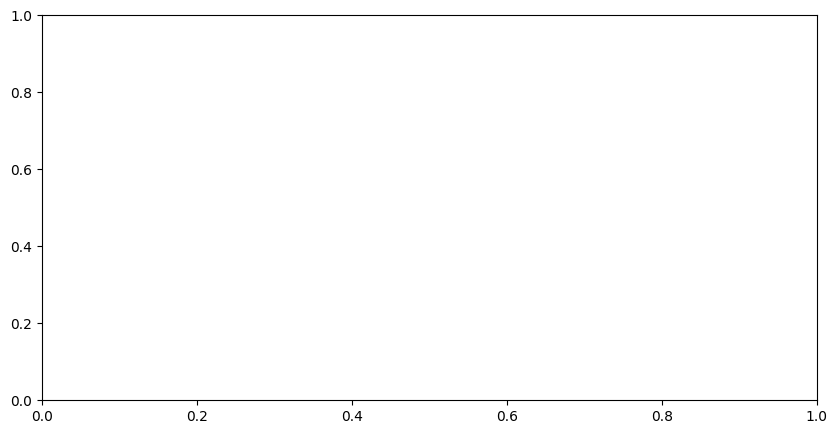

In [13]:
from torch.cuda.amp import autocast, GradScaler
scaler = GradScaler(enabled=torch.cuda.is_available()) # Enable only if using CUDA

print("Starting training...")
start_time = time.time()
global_step = 0
# No need for these lists if logging primarily to WandB
training_losses = []
validation_losses = []

# Setup Profiler if enabled (can run alongside WandB)
profiler = None
if config.profiler_enabled:
    os.makedirs(config.profile_dir, exist_ok=True)
    profiler_schedule = torch.profiler.schedule(wait=1, warmup=config.profile_warmup, active=config.profile_batches, repeat=1)
    profiler = profile(
        activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA] if device.type == 'cuda' else [ProfilerActivity.CPU],
        schedule=profiler_schedule,
        on_trace_ready=torch.profiler.tensorboard_trace_handler(config.profile_dir),
        record_shapes=True, profile_memory=True, with_stack=False
    )
    print(f"Profiler enabled. Results will be saved to {config.profile_dir}")
    print(f"Profiling schedule: Wait=1, Warmup={config.profile_warmup}, Active={config.profile_batches}, Repeat=1")
    profiler.start()


for epoch in range(config.epochs):
    epoch_start_time = time.time()
    model.train()
    epoch_loss = 0.0
    num_batches = len(train_loader)
    pbar = tqdm(enumerate(train_loader), total=num_batches, desc=f"Epoch {epoch+1}/{config.epochs} [Train]")

    for batch_idx, batch in pbar:
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        labels = batch['labels'].to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        # Use autocast for forward pass and loss calculation
        with autocast(enabled=torch.cuda.is_available()):
          with record_function("model_forward"):
              logits = model(input_ids) # Shape: (batch_size, max_len, num_items + 1)

          logits_flat = logits.view(-1, logits.size(-1))
          labels_flat = labels.view(-1)

          with record_function("loss_computation"):
              loss = criterion(logits_flat, labels_flat)

        # Scale loss and call backward
        with record_function("backward_pass"):
             scaler.scale(loss).backward()

        # Unscale gradients and step optimizer
        with record_function("optimizer_step"):
             scaler.step(optimizer)
             scaler.update() # Update scale for next iteration

        current_loss = loss.item()
        epoch_loss += current_loss
        global_step += 1

        # Log batch loss to WandB and console periodically <<< WANDB LOGGING
        if wandb_run and (batch_idx % config.log_freq == 0 or batch_idx == num_batches - 1):
            wandb.log({
                "train/batch_loss": current_loss,
                "global_step": global_step,
                # Optional: Log learning rate if it changes
                "train/learning_rate": optimizer.param_groups[0]['lr']
            })
            avg_loss_so_far = epoch_loss / (batch_idx + 1)
            pbar.set_postfix(loss=f"{avg_loss_so_far:.4f}", current_loss=f"{current_loss:.4f}")
        elif batch_idx % config.log_freq == 0 or batch_idx == num_batches - 1:
             # Update console even if WandB failed
             avg_loss_so_far = epoch_loss / (batch_idx + 1)
             pbar.set_postfix(loss=f"{avg_loss_so_far:.4f}", current_loss=f"{current_loss:.4f}")


        if profiler:
             profiler.step()

    avg_train_loss = epoch_loss / num_batches

    # --- Validation Phase ---
    model.eval()
    val_loss = 0.0
    val_batches = len(val_loader)
    val_pbar = tqdm(val_loader, total=val_batches, desc=f"Epoch {epoch+1}/{config.epochs} [Validate]")
    with torch.no_grad():
        for batch in val_pbar:
            input_ids = batch['input_ids'].to(device, non_blocking=True)
            labels = batch['labels'].to(device, non_blocking=True)
            logits = model(input_ids)
            logits_flat = logits.view(-1, logits.size(-1))
            labels_flat = labels.view(-1)
            loss = criterion(logits_flat, labels_flat)
            val_loss += loss.item()
            val_pbar.set_postfix(loss=f"{(val_loss / (val_pbar.n + 1)):.4f}")

    avg_val_loss = val_loss / val_batches
    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time

    # Log epoch metrics to WandB <<< WANDB LOGGING
    epoch_metrics = {
        "epoch": epoch + 1,
        "train/avg_loss": avg_train_loss,
        "val/avg_loss": avg_val_loss,
        "epoch/duration_sec": epoch_duration
    }
    if wandb_run:
        wandb.log(epoch_metrics)

    # Also print to console
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Duration: {str(datetime.timedelta(seconds=int(epoch_duration)))}")
    print(f"  Average Training Loss: {avg_train_loss:.4f}")
    print(f"  Average Validation Loss: {avg_val_loss:.4f}")
    print("-" * 30)


if profiler:
    profiler.stop()
    print("Profiling finished. Trace saved.")

end_time = time.time()
total_time = end_time - start_time
print(f"\nTotal Training finished in: {str(datetime.timedelta(seconds=int(total_time)))}")

# Optional: Plot losses - WandB provides better interactive plots
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(1, config.epochs + 1), training_losses, label='Training Loss')
plt.plot(range(1, config.epochs + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# --- Finish WandB Run ---
if wandb_run:
    print("Finishing WandB run...")
    wandb.finish()
    print("WandB run finished.")

In [14]:
# Option 1: Standard PyTorch Save + wandb.save (Uploads the local file)
save_dir = os.path.join(config.DATA_DIR, "checkpoints")
os.makedirs(save_dir, exist_ok=True) # Create directory if it doesn't exist
save_path = os.path.join(save_dir, f"bert4rec_{config.DATASET_NAME}_e{config.epochs}.pth")

checkpoint = {
    'epoch': config.epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'config': vars(config),
    'num_items': num_items,
    'mask_token_idx': config.MASK
}
torch.save(checkpoint, save_path)
print(f"Model checkpoint saved locally to {save_path}")

# Upload the saved checkpoint file to the current WandB run
if wandb_run:
     try:
         wandb.save(save_path, base_path=config.DATA_DIR) # Saves file relative to DATA_DIR in WandB artifacts
         print(f"Model checkpoint uploaded to WandB run.")
     except Exception as e:
         print(f"Could not upload checkpoint to WandB: {e}")


# Option 2: Using WandB Artifacts (More robust versioning)
if wandb_run:
    print("Saving model as WandB Artifact...")
    artifact = wandb.Artifact(f'bert4rec-{config.RUN_NAME}', type='model', metadata=vars(config))
    torch.save(model.state_dict(), 'model.pth') # Save model state dict locally first
    artifact.add_file('model.pth') # Add the file to the artifact
    # Save other necessary info like num_items, mask_token_idx if needed for reloading
    # with artifact.new_file('model_info.json', mode='w') as f:
    #     import json
    #     json.dump({'num_items': num_items, 'mask_token_idx': config.MASK}, f)

    wandb_run.log_artifact(artifact) # Log the artifact to the run
    print("Model artifact saved to WandB.")
    os.remove('model.pth') # Clean up local file after logging artifact

Model checkpoint saved locally to ./data_bert4rec/checkpoints/bert4rec_ml-20m_e5.pth
Model checkpoint uploaded to WandB run.
Saving model as WandB Artifact...
Model artifact saved to WandB.
